# The project report:


---




1.   Data Extraction:\
In this project, we utilized the Selenium and BeautifulSoup libraries in Python for web scraping to gather detailed information about watches from the Raymond Weil website. The combined functionality of these libraries enabled us to navigate the website, retrieve watch URLs, and extract relevant details for subsequent analysis.

2.   Data Overview:\
Our dataset comprises 40 columns, encompassing crucial watch details such as reference number, brand, type, case material, and more. The dataset is divided evenly between 12 men's watches and 12 women's watches, offering a comprehensive overview of the available timepieces.
3. Insight on Price Information:\
It is crucial to highlight that the website lacks pricing details for watches in Saudi Arabia. As a result, the "price" column in our CSV file is left empty for all entries, creating a significant issue in our dataset analysis. Therefore, we have set the currency column to a hardcoded USD value, emphasizing the significance of this absence in our exploration.
4. Challenges:\
Several columns in our data encounter issues with case sensitivity, treating uppercase and lowercase variations as distinct values. For example, in the "type" column, both "Gents" and "Ladies" with mixed cases result in four unique entries instead of the intended two. You can see the data visualization of this problem in section 8.1 and 8.2.



---















##1- Install and set up the necessary drivers for Selenium


In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,796 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 2,025 kB in 4s (459 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
c

##2- Import Libraries and Setup WebDriver

Here we import necessary Python libraries for web scraping and initialize the Selenium WebDriver with required options for headless browsing.


In [2]:
# Import necessary libraries
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import warnings
import csv

# Suppress FutureWarnings and UserWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Setup Selenium WebDriver
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--no-sandbox')
driver = webdriver.Chrome(options=options)

##3- Define Functions to Scrape URLs
This function `scrape_watch_urls` will visit each section and collect all the watch URLs available on that page.


In [3]:
def scrape_watch_urls(sections):
    """Scrapes all watch URLs from the provided sections.

    Args:
        sections (list): List of URLs of the sections to scrape.

    Returns:
        list: List of watch URLs.
    """
    all_watch_urls = []
    for section_url in sections:
        driver.get(section_url)
        watch_links = driver.find_elements(By.CSS_SELECTOR, "a.woocommerce-LoopProduct-link.woocommerce-loop-product__link")
        section_watch_urls = [link.get_attribute('href') for link in watch_links]
        all_watch_urls.extend(section_watch_urls)
    return all_watch_urls

##4- Define Function to Extract Watch Details
`extract_watch_details` function visits each watch URL and extracts the detailed information about the watch.


In [4]:
def extract_watch_details(url):
    """Extracts watch details from the given URL.

    Args:
        url (str): URL of the watch to extract details from.

    Returns:
        dict: Dictionary containing extracted watch details.
    """
    driver.get(url)
    try:
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "body")))
        page_source = driver.page_source
    except TimeoutException:
        print("Page load timed out.")
        return {}

    # Parse the page with BeautifulSoup
    soup = BeautifulSoup(page_source, 'html.parser')
    # Initialize a dictionary to store watch details
    watch_data = {
        # Default values and static information
        "watch_URL": url,
        "brand": "Raymond Weil",
        "currency": "USD",
        "made_in": "Switzerland",
        # Fields set to None because data is not available
        "year_introduced": None,
        "marketing_name": None,
        "style": None,
        "price": None,
        "case_finish": None,
        "between_lugs": None,
        "lug_to_lug": None,
        "bezel_material": None,
        "bezel_color": None,
        "weight": None,
        "frequency":  None,
        "jewels":  None,
        "features":  None
    }

    # Extract parent_model
    watch_div = soup.find('div', class_='rwproduct__datas__tech__inner')
    if watch_div:
        watch_table = watch_div.find('table', class_='rwproduct__datas__tech__table')
        if watch_table:
            collection_element = watch_table.find('th', string='Collection')
            if collection_element:
                collection_td = collection_element.find_next('td')
                watch_data["parent_model"] = collection_td.text.strip() if collection_td else None

    # Extract reference_number
    ref_num_element = soup.find('div', class_="rwproduct__main__infos__sku")
    if ref_num_element:
        watch_data["reference_number"] = ref_num_element.get_text(strip=True)

    # Extract specific_model and nickname
    specific_model_element = soup.find('div', class_='rwproduct__main__infos__name').div
    if specific_model_element:
        watch_data["specific_model"] = specific_model_element.text.strip()
        watch_data["nickname"] = specific_model_element.text.strip()

    # Extract image_URL
    image_element = soup.select_one('.woocommerce-product-gallery__image img')
    if image_element and 'src' in image_element.attrs:
        watch_data["image_URL"] = image_element['src']

    # Extract type
    size_element = watch_table.find('th', string='Size').find_next('td')
    watch_data["type"] = size_element.text.strip() if size_element else None

    # Extract case_shape
    shape_element = watch_table.find('th', string='Shape')
    if shape_element:
        shape_td = shape_element.find_next('td')
        watch_data["case_shape"] = shape_td.text.strip() if shape_td else None

    # Extract case_material
    material_element = watch_table.find('th', string='Case material')
    if material_element:
        material_td = material_element.find_next('td')
        watch_data["case_material"] = material_td.text.strip() if material_td else None

    # Extract caseback
    caseback_element = watch_table.find('th', string='Case back')
    if caseback_element:
        caseback_td = caseback_element.find_next('td')
        watch_data["caseback"] = caseback_td.text.strip() if caseback_td else None

    # Extract diameter
    diameter_element = watch_table.find('th', string='Case size')
    if diameter_element:
        diameter_td = diameter_element.find_next('td')
        watch_data["diameter"] = diameter_td.text.strip() if diameter_td else None

    # Extract case_thickness
    case_thickness_element = watch_table.find('th', string='Case thickness')
    if case_thickness_element:
        case_thickness_td = case_thickness_element.find_next('td')
        watch_data["case_thickness"] = case_thickness_td.text.strip() if case_thickness_td else None

    # Extract crystal
    crystal_element = watch_table.find('th', string='Crystal')
    if crystal_element:
        crystal_td = crystal_element.find_next('td')
        watch_data["crystal"] = crystal_td.text.strip() if crystal_td else None

    # Extract water_resistance
    water_resistance_element = watch_table.find('th', string='Water resistance')
    if water_resistance_element:
        water_resistance_td = water_resistance_element.find_next('td')
        watch_data["water_resistance"] = water_resistance_td.text.strip() if water_resistance_td else None

    # Extract dial_color
    dial_color_element = watch_table.find('th', string='Dial')
    if dial_color_element:
        dial_color_td = dial_color_element.find_next('td')
        watch_data["dial_color"] = dial_color_td.text.strip() if dial_color_td else None

    # Extract numerals
    if dial_color_element:
        watch_data["numerals"] = dial_color_td.text.strip() if dial_color_td else None

    # Extract bracelet material
    bracelet_material_element = watch_table.find('th', string='Bracelet/Strap')
    if bracelet_material_element:
        bracelet_material_td = bracelet_material_element.find_next('td')
        watch_data["bracelet_material"] = bracelet_material_td.text.strip() if bracelet_material_td else None

    # Extract bracelet_color
    bracelet_color_element = bracelet_material_element
    if bracelet_color_element:
        bracelet_color_td = bracelet_color_element.find_next('td')
        watch_data["bracelet_color"] = bracelet_color_td.text.strip() if bracelet_color_td else None

    # Extract clasp_type
    clasp_type_element = watch_table.find('th', string='Clasp')
    if clasp_type_element:
        clasp_type_td = clasp_type_element.find_next('td')
        watch_data["clasp_type"] = clasp_type_td.text.strip() if clasp_type_td else None

    # Extract movement and caliber
    movement_element = watch_table.find('th', string='Movement')
    if movement_element:
        movement_td = movement_element.find_next('td')
        watch_data["movement"] = movement_td.text.strip() if movement_td else None
        watch_data["caliber"] = movement_td.text.strip() if movement_td else None

    # Extract power_reserve
    power_reserve_element = watch_table.find('th', string='Power reserve')
    if power_reserve_element:
        power_reserve_td = power_reserve_element.find_next('td')
        watch_data["power_reserve"] = power_reserve_td.text.strip() if power_reserve_td else None

    # Extract description
    description_element = soup.select_one('.rwproduct__datas__description__inner')
    if description_element:
        watch_data["description"] = "\n".join(p.text.strip() for p in description_element.find_all('p')) if description_element else None

    # Extract short description
    # First, attempt to extract from a span with data-sheets-value attribute
    short_description_element = soup.select_one('.rwproduct__main__infos__name span[data-sheets-value]')
    if not short_description_element:
        # If not found in span, try finding the text in the second <p> tag
        short_description_element = soup.select_one('.rwproduct__main__infos__name p:nth-of-type(2)')

    if short_description_element:
        # Check if the element has 'data-sheets-value' attribute to determine how to extract text
        if 'data-sheets-value' in short_description_element.attrs:
            contents = short_description_element.contents
            short_description_text = ''.join(str(content) for content in contents if content and str(content).strip())
        else:
            short_description_text = short_description_element.text.strip()
        watch_data["short_description"] = short_description_text
    else:
        watch_data["short_description"] = None

    return watch_data

##5- Define Function to Filter Watch Details
The `filter_watch_details` function filters the extracted information based on the given set of column names for CSV output.


In [5]:
def filter_watch_details(details, columns):
    """Filters watch details based on specified columns.

    Args:
        details (dict): Dictionary containing watch details.
        columns (list): List of columns to include in the filtered details.

    Returns:
        dict: Dictionary containing filtered watch details.
    """
    return {col: details.get(col, '') for col in columns}

##6- Scrape Watch URLs
Execute the scraping of watch URLs from the given sections.


In [6]:
# Define the URLs for men's and women's watch sections
sections = [
    "https://www.raymond-weil.com/en/collections/watches-en/mens-en/?v=rwrow",
    "https://www.raymond-weil.com/en/collections/watches-en/womens-en/?v=rwrow"
]

# Scrape all URLs
all_urls = scrape_watch_urls(sections)

## 7- Write to CSV
Write the extracted watch details into a CSV file, ensuring each watch's information is properly formatted into the correct columns.


In [7]:
# Get the current date and time for a unique file name every time the script runs
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M")

# Constructing a file name: 'RaymondWeil_WatchData_YYYY-MM-DD_HH-MM.csv'
csv_file = f"RaymondWeil_WatchData_{timestamp}.csv"
csv_columns = ["", "reference_number", "watch_URL", "type", "brand", "year_introduced", "parent_model", "specific_model", "nickname", "marketing_name", "style", "currency", "price", "image_URL", "made_in", "case_shape", "case_material", "case_finish", "caseback", "diameter", "between_lugs", "lug_to_lug", "case_thickness", "bezel_material", "bezel_color", "crystal", "water_resistance", "weight", "dial_color", "numerals", "bracelet_material", "bracelet_color", "clasp_type", "movement", "caliber", "power_reserve", "frequency", "jewels", "features", "description", "short_description"]

# Write the extracted details to the CSV file
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for url in all_urls:
        watch_details = extract_watch_details(url)
        watch_details[""] = "value"  # Insert the 'value' text in the unnamed column
        filtered_details = filter_watch_details(watch_details, csv_columns)
        writer.writerow(filtered_details)

# Clean up by closing the Selenium WebDriver
driver.quit()

## 8- Data Visualization
Below are visualizations that highlight key details and data quality of the watch collection.






---

### 8.1- Count of Watches by Type:

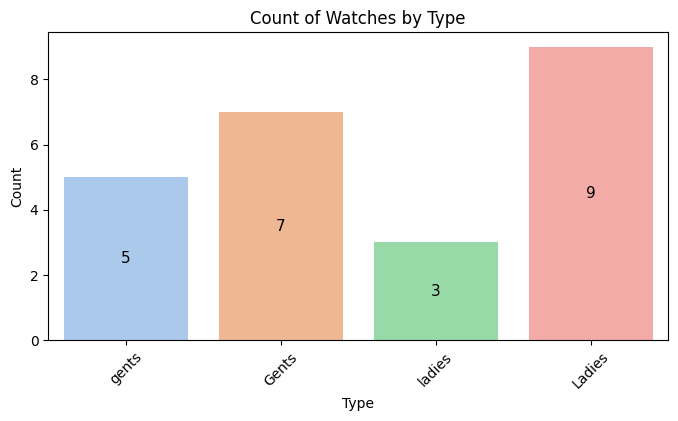

In [8]:
df = pd.read_csv(csv_file)

light_colors = sns.color_palette("pastel")

plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df, x='type', palette=light_colors)
plt.title('Count of Watches by Type')
plt.xticks(rotation=45)
plt.xlabel('Type')
plt.ylabel('Count')

for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_height() / 2
    value = int(p.get_height())
    ax.text(_x, _y, value, ha="center", va="center", fontsize=11, color='black')
plt.show()

### 8.2- Count of Watches by Parent Model:







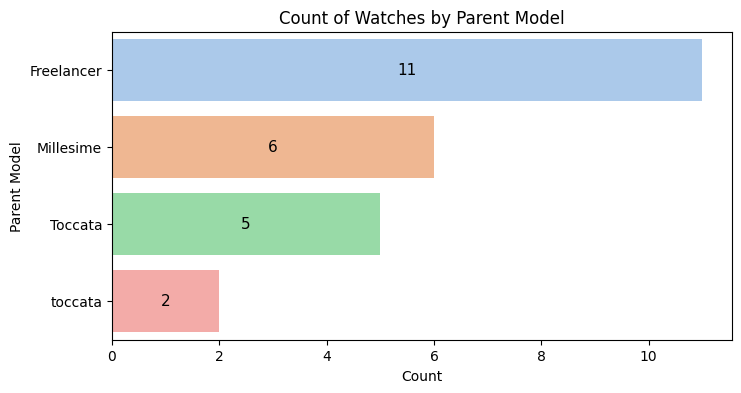

In [9]:
light_colors = sns.color_palette("pastel")
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df, y='parent_model', palette=light_colors, order=df['parent_model'].value_counts().index)
plt.title('Count of Watches by Parent Model')
plt.xlabel('Count')
plt.ylabel('Parent Model')

for p in ax.patches:
    bar_width = p.get_width()
    ax.annotate(f'{int(bar_width)}',
                xy=(bar_width / 2, p.get_y() + p.get_height() / 2),
                ha='center', va='center',
                fontsize=11, color='black',
                xytext=(0, 0),
                textcoords='offset points')
plt.show()

###8.3- Word Cloud from Short Descriptions:

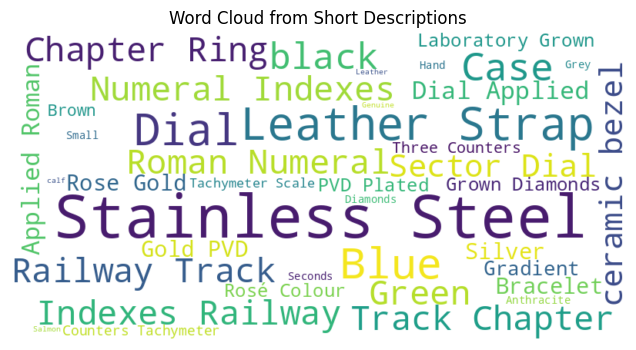

In [10]:
all_descriptions = ' '.join(df['short_description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_descriptions)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Short Descriptions')
plt.show()

###8.4- Presence of Price Information:




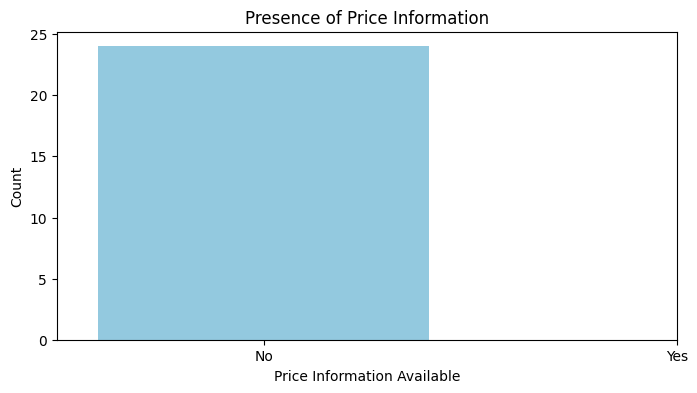

In [11]:
plt.figure(figsize=(8, 4))
df['price_presence'] = df['price'].notnull()
sns.countplot(data=df, x='price_presence', palette=['skyblue', 'orange'])
plt.title('Presence of Price Information')
plt.xlabel('Price Information Available')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

###8.5- Top 10 Parent Models:





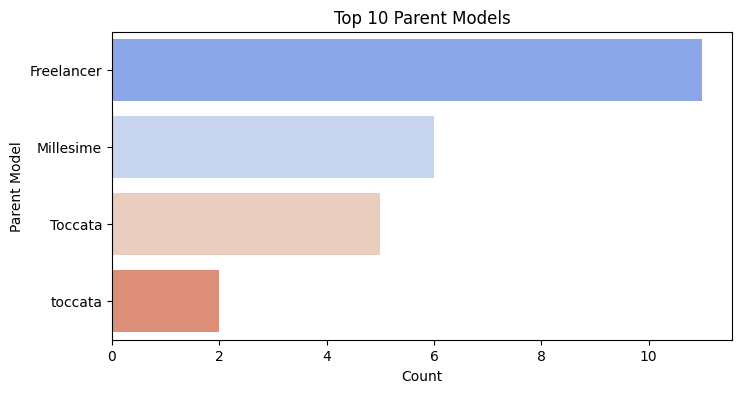

In [12]:
top_parent_models = df['parent_model'].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_parent_models.values, y=top_parent_models.index, palette='coolwarm')
plt.title('Top 10 Parent Models')
plt.xlabel('Count')
plt.ylabel('Parent Model')
plt.show()

###8.6- Case Material Distribution:



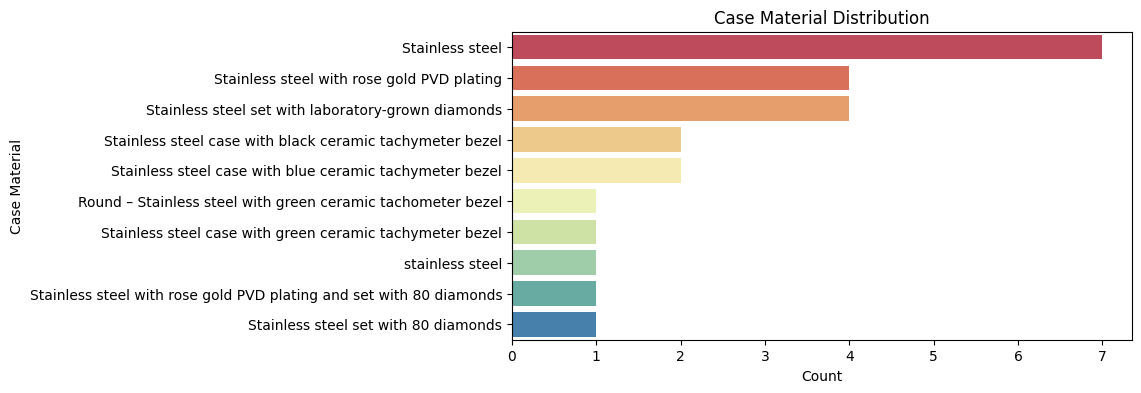

In [13]:
case_material_dist = df['case_material'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=case_material_dist.values, y=case_material_dist.index, palette='Spectral')
plt.title('Case Material Distribution')
plt.xlabel('Count')
plt.ylabel('Case Material')
plt.show()

###8.7- Watch Movement Type Distribution:





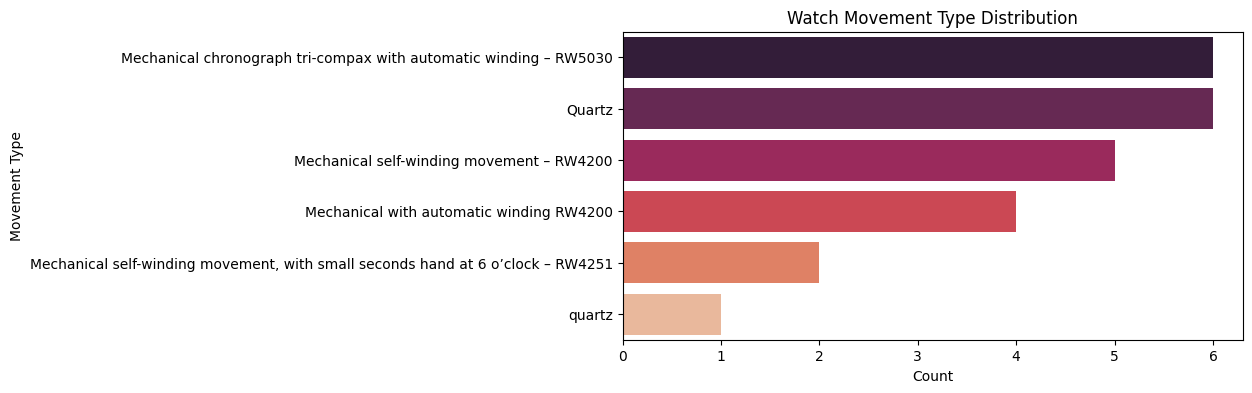

In [14]:
movement_type_dist = df['movement'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=movement_type_dist.values, y=movement_type_dist.index, palette='rocket')
plt.title('Watch Movement Type Distribution')
plt.xlabel('Count')
plt.ylabel('Movement Type')
plt.show()

###8.8- Distribution of Case Diameter:





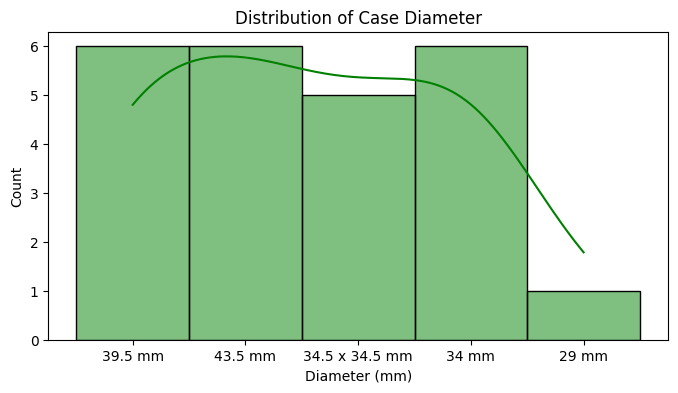

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='diameter', bins=15, kde=True, color='green')
plt.title('Distribution of Case Diameter')
plt.xlabel('Diameter (mm)')
plt.ylabel('Count')
plt.show()

###8.9- Water Resistance Distribution:





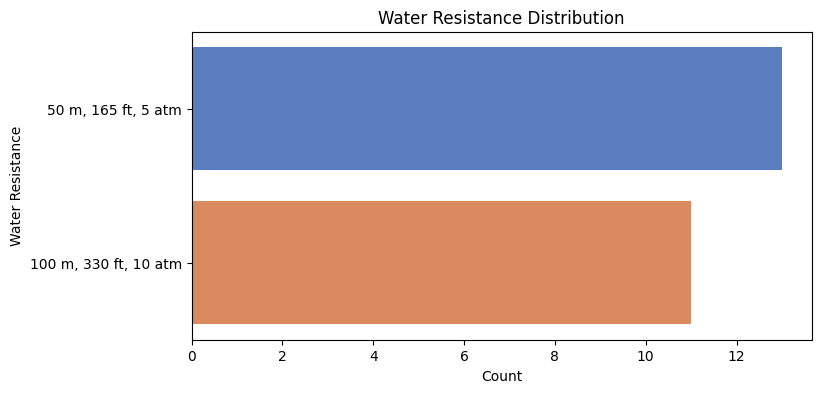

In [16]:
water_resistance_dist = df['water_resistance'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=water_resistance_dist.values, y=water_resistance_dist.index, palette='muted')
plt.title('Water Resistance Distribution')
plt.xlabel('Count')
plt.ylabel('Water Resistance')
plt.show()

###8.10- Top 10 Dial Colors:





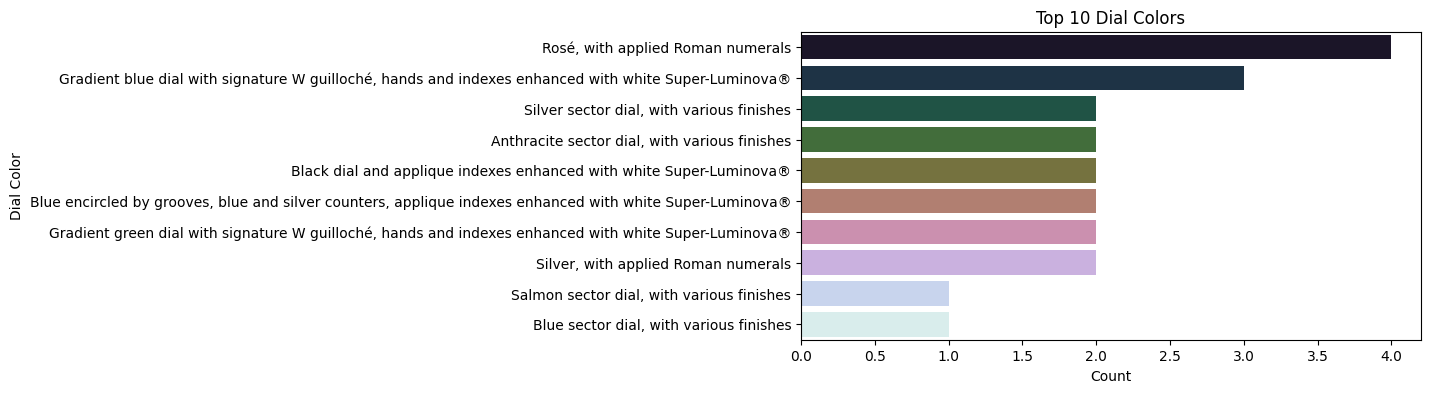

In [17]:
dial_color_dist = df['dial_color'].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=dial_color_dist.values, y=dial_color_dist.index, palette='cubehelix')
plt.title('Top 10 Dial Colors')
plt.xlabel('Count')
plt.ylabel('Dial Color')
plt.show()

###8.11- Count of Missing Values in Each Column:





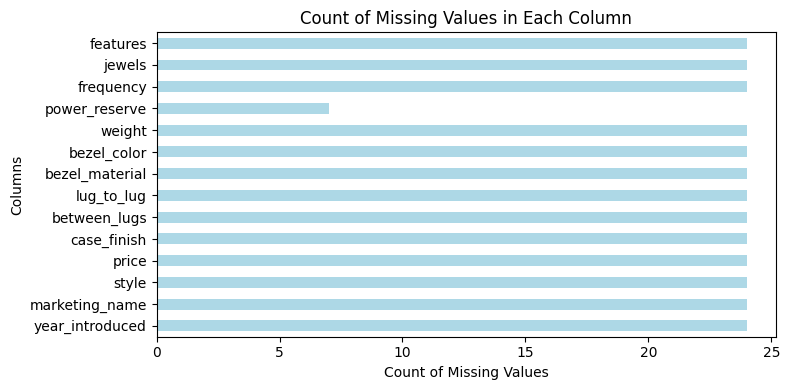

In [18]:
missing_values_count = df.isnull().sum()
missing_values_count = missing_values_count[missing_values_count > 0]
plt.figure(figsize=(8, 4))
missing_values_count.plot(kind='barh', color='lightblue')
plt.title('Count of Missing Values in Each Column')
plt.xlabel('Count of Missing Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()

###8.12- Count of Unique Values in Each Column:





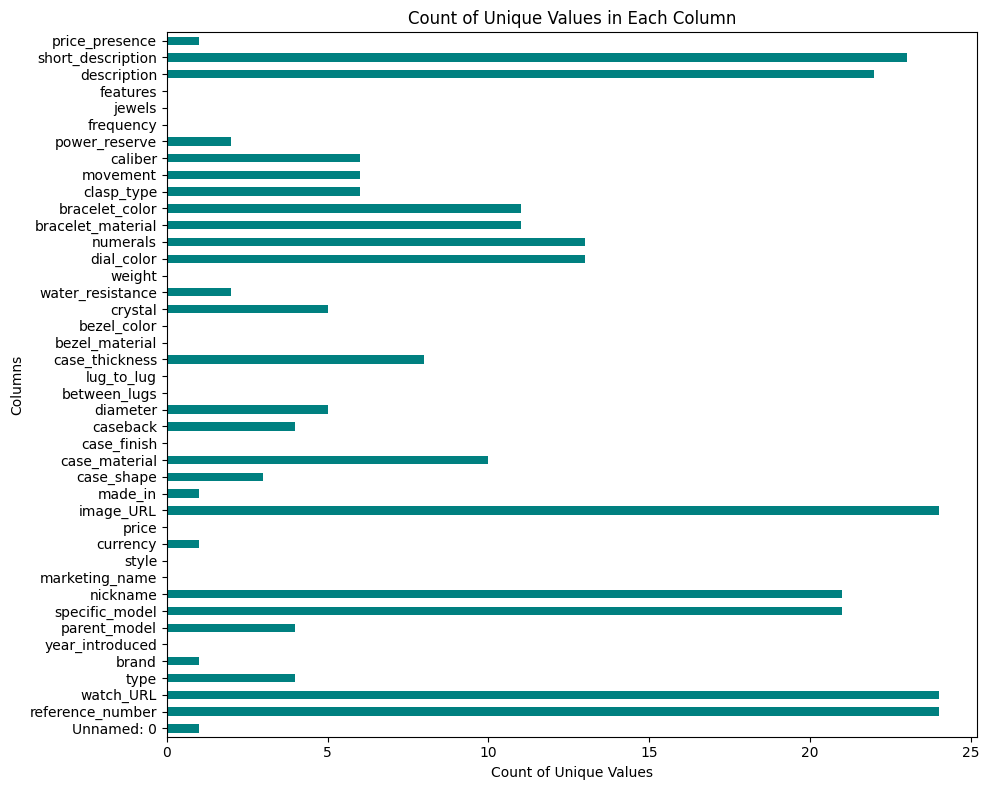

In [19]:
unique_values_count = df.nunique()
plt.figure(figsize=(10, 8))
unique_values_count.plot(kind='barh', color='teal')
plt.title('Count of Unique Values in Each Column')
plt.xlabel('Count of Unique Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()